In [171]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A
# from ipywidgets import IntProgress
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

from torchvision.ops import batched_nms

# from coco_utils import get_coco_api_from_dataset

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
TRAIN_PATH = 'train/'
df_train = pd.read_csv('train.csv')
# df_train_meta = pd.read_csv('train_meta.csv')
df_train

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [68]:
df_train.fillna(0, inplace = True)

In [69]:
print(df_train.shape)
df_train.head()
df_train.to_csv('train.csv', index=False)

(67914, 8)


In [82]:
print(df_train_meta.shape)
df_train_meta.head()

(15000, 3)


,image_id,dim0,dim1
0,4d390e07733ba06e5ff07412f09c0a92,3000,3000
1,289f69f6462af4933308c275d07060f0,3072,3072
2,68335ee73e67706aa59b8b55b54b11a4,2836,2336
3,7ecd6f67f649f26c05805c8359f9e528,2952,2744
4,2229148faa205e881cf0d932755c9e40,2880,2304


In [83]:
import matplotlib.pyplot as plt
import numpy as np

def draw_box_on_array(row, np_array):
    xy = [
        row["x_min"],
        row["y_min"],
        row["x_max"],
        row["y_max"],
    ]
    x_mid = (xy[2] + xy[0]) // 2
    y_mid = (xy[3] + xy[1]) // 2
    
    offset = 16
    np_array[y_mid-offset:y_mid+offset, x_mid-offset:x_mid+offset] += 1
    
def get_bbox(df, class_id):
    np_array = np.zeros(shape=(IMAGE_SIZE, IMAGE_SIZE))
    if class_id == 14:
        return np_array
    for _, row in df[df["class_id"] == class_id].iterrows():
        draw_box_on_array(row, np_array)
    np_array = np_array / np.max(np_array)
#     np_array[np_array > 0] = 1
    return np_array

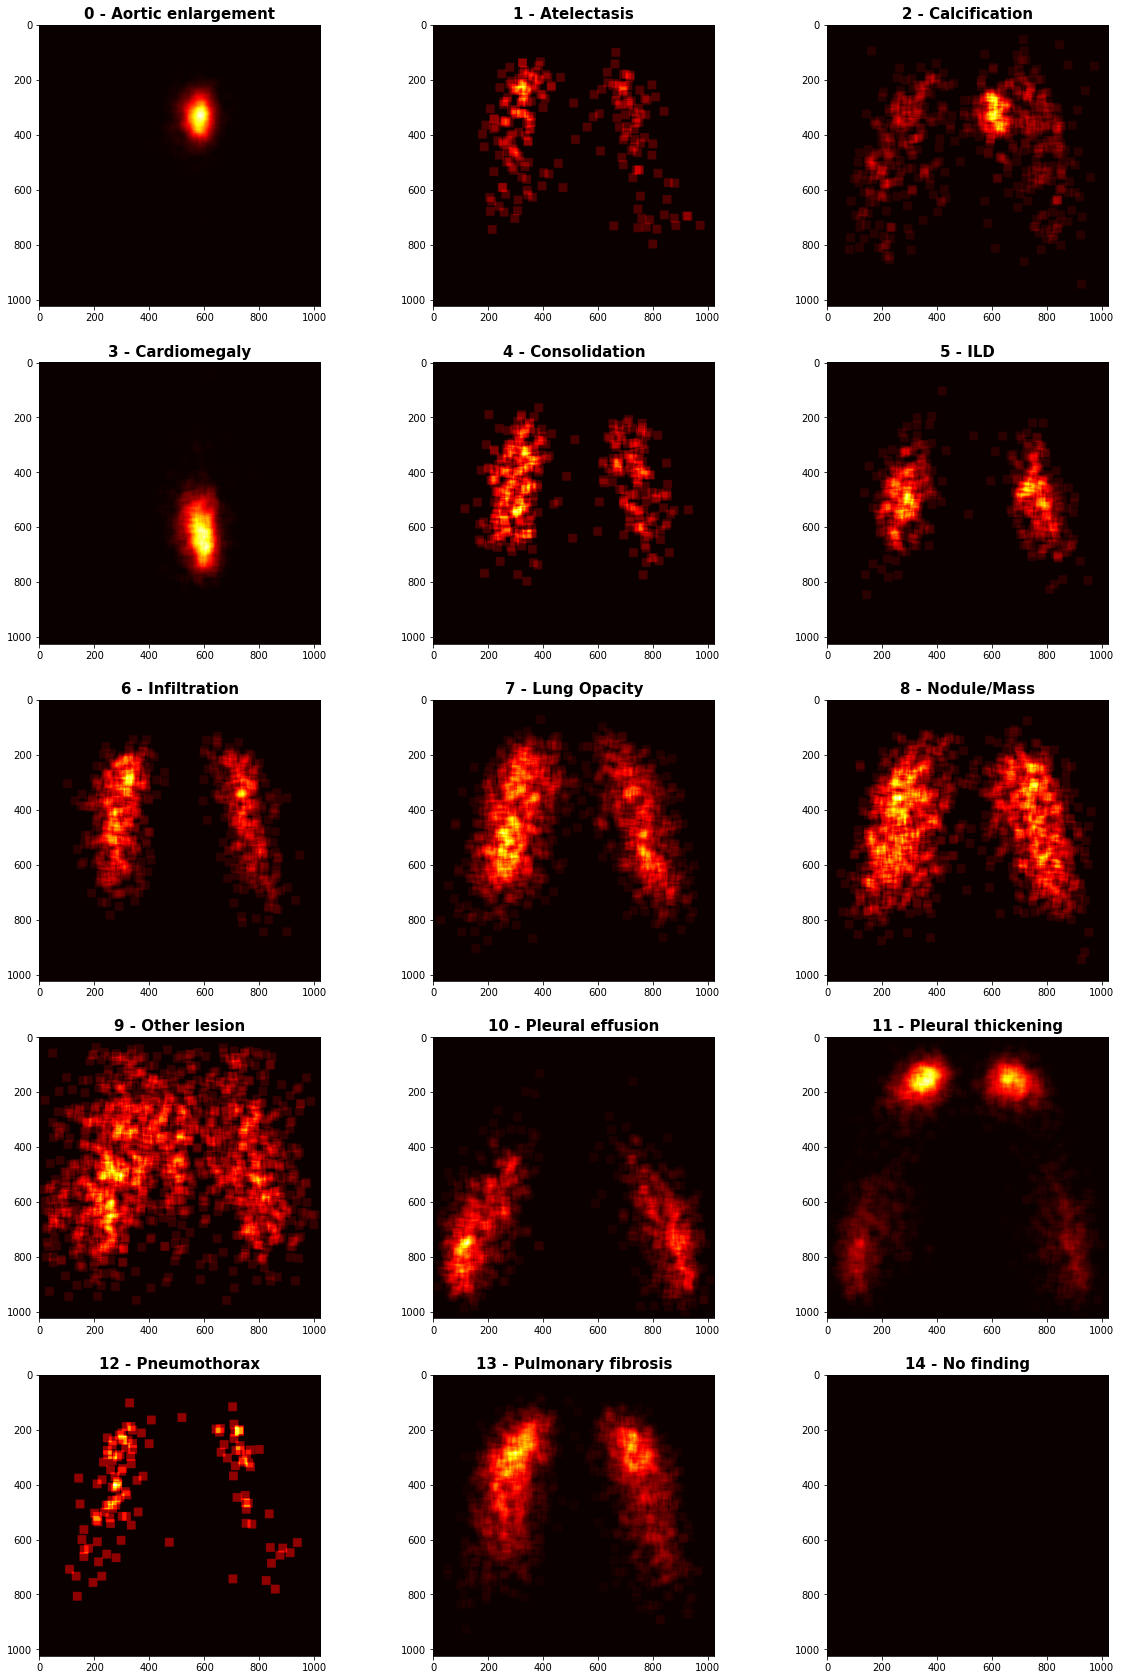

In [86]:
classes = [
    "0 - Aortic enlargement",
    "1 - Atelectasis",
    "2 - Calcification",
    "3 - Cardiomegaly", 
    "4 - Consolidation",
    "5 - ILD",
    "6 - Infiltration",
    "7 - Lung Opacity",
    "8 - Nodule/Mass",
    "9 - Other lesion",
    "10 - Pleural effusion",
    "11 - Pleural thickening",
    "12 - Pneumothorax",
    "13 - Pulmonary fibrosis",
    "14 - No finding",
]

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(get_bbox(df, i), cmap='hot')
    _ = ax.set_title(classes[i], fontweight="bold", size=15)

In [11]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

In [46]:
df = df_train
clear = df[df.class_id == 14].groupby(['image_id', 'class_name']).mean().reset_index()
abnormal = df[df.class_id != 14]
df = pd.concat([clear, abnormal])

print(len(abnormal.image_id.unique()))
meta = pd.read_csv('train_meta.csv').set_index('image_id')

df = abnormal

df = df.set_index('image_id')
df['fold_id'] = -1

4394


In [168]:
df = pd.read_csv('10_fold_dedub_abnormal_org_size.csv')
df = df.set_index('image_id')
df['fold_id'] = int(-1)

In [169]:
X = df.groupby(['image_id']).agg(lambda x: list(x)).reset_index()
X_numpy = X.image_id.to_numpy()

def convert_to_hot(x):
    
    y = torch.zeros(15)
    y[torch.LongTensor([x]) - 1] = 1
    return y.numpy().astype('int')

Y = X.class_id.apply(convert_to_hot).to_numpy()
Y = np.array(Y.tolist())
print(Y.shape)

mskf = MultilabelStratifiedKFold(n_splits=5)
for fold, (train_index, val_index) in enumerate(mskf.split(X_numpy, Y)):

    ids = X_numpy[val_index]

    df.loc[ids, 'fold_id'] = int(fold)

# df = df.drop('index')
df = df.reset_index()
df

(4394, 15)


/home/usrg/miniconda3/envs/robert3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


,image_id,class_id,x_min,y_min,x_max,y_max,area,width,height,fold_id
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,932,567,1197,896,87185,3072,3072,4
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,900,587,1205,888,91805,3072,3072,4
2,0005e8e3701dfb1dd93d53e2ff537b6e,7,905,583,1203,890,91486,3072,3072,4
3,0005e8e3701dfb1dd93d53e2ff537b6e,8,932,567,1197,896,87185,3072,3072,4
4,0007d316f756b3fa0baea2ff514ce945,0,1235,1021,1482,1281,64220,2304,2880,3
...,...,...,...,...,...,...,...,...,...,...
20345,ffceb71a80efba3b83c88e11f4b9694b,13,1429,1152,1915,1280,62208,2109,2344,2
20346,ffe6f9fe648a7ec29a50feb92d6c15a4,0,1445,1038,1756,1342,94544,2685,2857,0
20347,ffe6f9fe648a7ec29a50feb92d6c15a4,3,1144,1849,2297,2384,616855,2685,2857,0
20348,ffe6f9fe648a7ec29a50feb92d6c15a4,9,563,1148,593,1185,1110,2685,2857,0


895


<AxesSubplot:xlabel='class_id', ylabel='count'>

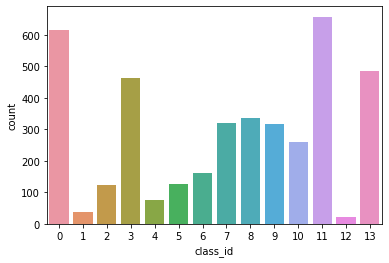

In [174]:
fold = 4
print(len(df[(df.fold_id == fold)].groupby('image_id').agg(lambda x: list(x)).reset_index()))

sns.countplot(x="class_id",data=df[(df.fold_id == fold)])

3499


<AxesSubplot:xlabel='class_id', ylabel='count'>

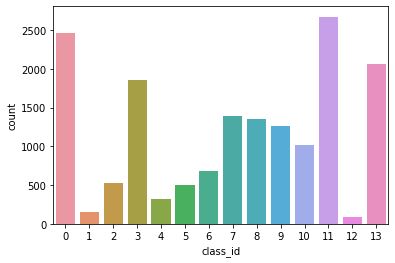

In [175]:
print(len(df[(df.fold_id != fold)].groupby('image_id').agg(lambda x: list(x)).reset_index()))
sns.countplot(x="class_id",data=df[(df.fold_id != fold)])

In [176]:
# df[df.fold_id == 1]
df.to_csv('5_fold_dedub_abnormal_org_size.csv', index=False)

In [122]:
pd.read_csv('10_fold_abnormal.csv')

,image_id,class_id,x_min,y_min,x_max,y_max,area,width,height,fold_id
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,466,283,598,448,21780,1536,1536,4
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,450,293,602,444,22952,1536,1536,4
2,0005e8e3701dfb1dd93d53e2ff537b6e,8,466,283,598,448,21780,1536,1536,4
3,0005e8e3701dfb1dd93d53e2ff537b6e,7,451,292,601,444,22800,1536,1536,4
4,0007d316f756b3fa0baea2ff514ce945,5,923,704,1046,1048,42312,1152,1440,2
...,...,...,...,...,...,...,...,...,...,...
22708,ffceb71a80efba3b83c88e11f4b9694b,13,714,576,957,640,15552,1054,1172,6
22709,ffe6f9fe648a7ec29a50feb92d6c15a4,9,281,574,296,592,270,1342,1428,0
22710,ffe6f9fe648a7ec29a50feb92d6c15a4,0,722,519,878,671,23712,1342,1428,0
22711,ffe6f9fe648a7ec29a50feb92d6c15a4,3,572,915,1151,1179,152856,1342,1428,0


In [21]:
len(df.reset_index().image_id.unique())

4394

In [256]:
d = pd.read_csv('kfold_detection_train.csv')
d

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,index,rad_id,fold_id
0,000434271f63a053c4128a0ba6352c7f,No finding,14,0,0,1023,1023,NaN,NaN,3
1,00053190460d56c53cc3e57321387478,No finding,14,0,0,1023,1023,NaN,NaN,2
2,0006e0a85696f6bb578e84fafa9a5607,No finding,14,0,0,1023,1023,NaN,NaN,1
3,000ae00eb3942d27e0b97903dd563a6e,No finding,14,0,0,1023,1023,NaN,NaN,0
4,00176f7e1b1cb835123f95960b9a9efd,No finding,14,0,0,1023,1023,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...
46697,52951d7de2485aba8ed62629eee4d254,Other lesion,9,134,512,170,536,67774.0,R9,3
46698,52951d7de2485aba8ed62629eee4d254,Cardiomegaly,3,326,558,717,672,67775.0,R8,3
46699,1224f07d895107573588225f692e94f9,Aortic enlargement,0,501,323,640,446,67848.0,R10,2
46700,1224f07d895107573588225f692e94f9,Aortic enlargement,0,525,311,638,442,67849.0,R8,2
